# Predicción de unidades vendidas productos RDS para el resto del 2025

## Modelo ARIMA con auto_arima

In [154]:
# Librerías
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [155]:
# Base de datos
df_modelo = pd.read_excel("/Users/martincarrasco/Desktop/Martín_Carrasco/Reportes/Interanuales/Cuentas RDS/Ventas Consolidado RDS 2024-2025 (hasta 15-06-2025).xlsx", sheet_name = "Hoja1")
df_modelo = df_modelo[df_modelo["Nombre Vendedor"] == "REPUESTOS DEL SOL"]
df_modelo

,Titulo_Publicacion,Marca,Categoría,Subcategoría,Año,Mes,Fecha_Compra,Nombre Vendedor,Unidades_Vendidas,Volumen_de_Ventas_Moneda_Local
1,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,Suspensión y Dirección,Dirección Hidráulica,2024,1,2024-01-31,REPUESTOS DEL SOL,41,4919590.0
5,Cremallera Dirección Hidráulica Chevrole,GENÉRICO,Suspensión y Dirección,Dirección Hidráulica,2024,12,2024-12-31,REPUESTOS DEL SOL,37,3551630.0
9,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB, VALEO",Motores,Distribución,2024,10,2024-10-31,REPUESTOS DEL SOL,32,3199680.0
13,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,Suspensión y Dirección,Dirección Hidráulica,2024,3,2024-03-31,REPUESTOS DEL SOL,24,3101639.0
14,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB",Motores,Distribución,2024,6,2024-06-30,REPUESTOS DEL SOL,30,2999700.0
...,...,...,...,...,...,...,...,...,...,...
160164,Filtro Aceite Para Subaru Impreza 1.6 Ej,WURTEX,Filtros,Filtros de Aceite,2025,3,2025-03-31,REPUESTOS DEL SOL,1,4990.0
160167,Filtro Polen Chevrolet Spark Gt 1.2 B12d,ALTERNATIVA,Filtros,Filtros de Polen,2025,4,2025-04-30,REPUESTOS DEL SOL,1,4990.0
160174,Empaquetadura Tapa Valvula Para Changan,SANWA,Motores,Juntas,2025,4,2025-04-30,REPUESTOS DEL SOL,1,4990.0
160176,Filtro Aceite Para Nissan X-trail 2.5 Qr,MANDO,Filtros,Filtros de Aceite,2025,4,2025-04-30,REPUESTOS DEL SOL,1,4990.0


In [156]:
df_modelo.rename(columns={"Titulo_Publicacion": "Producto"}, inplace = True)
df_modelo = df_modelo[["Producto", "Marca", "Fecha_Compra", "Unidades_Vendidas"]]
df_modelo = df_modelo[
    ~((df_modelo["Fecha_Compra"].dt.year == 2025) &
      (df_modelo["Fecha_Compra"].dt.month == 6))
]
df_modelo

,Producto,Marca,Fecha_Compra,Unidades_Vendidas
1,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-01-31,41
5,Cremallera Dirección Hidráulica Chevrole,GENÉRICO,2024-12-31,37
9,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB, VALEO",2024-10-31,32
13,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-03-31,24
14,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB",2024-06-30,30
...,...,...,...,...
160164,Filtro Aceite Para Subaru Impreza 1.6 Ej,WURTEX,2025-03-31,1
160167,Filtro Polen Chevrolet Spark Gt 1.2 B12d,ALTERNATIVA,2025-04-30,1
160174,Empaquetadura Tapa Valvula Para Changan,SANWA,2025-04-30,1
160176,Filtro Aceite Para Nissan X-trail 2.5 Qr,MANDO,2025-04-30,1


In [157]:
fechas_completas = pd.date_range(start=df_modelo['Fecha_Compra'].min(),
                                  end=df_modelo['Fecha_Compra'].max(),
                                  freq='M')

producto_marca = df_modelo[['Producto', 'Marca']].drop_duplicates()

combinaciones = (
    producto_marca.assign(key=1)
    .merge(pd.DataFrame({'Fecha_Compra': fechas_completas, 'key': 1}), on='key')
    .drop('key', axis=1)
)

df_completo = combinaciones.merge(df_modelo, 
                                  on=['Producto', 'Marca', 'Fecha_Compra'], 
                                  how='left')

df_completo['Unidades_Vendidas'] = df_completo['Unidades_Vendidas'].fillna(0)

df_completo['Unidades_Vendidas'] = df_completo['Unidades_Vendidas'].astype(int)

/var/folders/lr/rkgxn4r50h712qndyykwjmfh0000gp/T/ipykernel_69221/2530887409.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_completas = pd.date_range(start=df_modelo['Fecha_Compra'].min(),


In [158]:
producto_marca

,Producto,Marca
1,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU
5,Cremallera Dirección Hidráulica Chevrole,GENÉRICO
9,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB, VALEO"
14,Kit Distribucion Mitsubishi L200 2.5 200,"MITSUBOSHI, GMB"
18,Caja De Direccion Hidraulica Chevrolet L,CHEVROLET
...,...,...
160137,Termostato Para Mitsubishi L200 1.6 Cami,BROALAU
160140,Filtro Aire Para Hyundai Elantra 1.8 Md,WURTEX
160161,Filtro Aceite Para Mazda Cx5 2.0 Pevps 2,MANDO
160164,Filtro Aceite Para Subaru Impreza 1.6 Ej,WURTEX


In [159]:
df_completo

,Producto,Marca,Fecha_Compra,Unidades_Vendidas
0,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-01-31,41
1,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-02-29,14
2,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-03-31,24
3,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-04-30,5
4,Cremallera Dirección Hidráulica Chevrole,YOKOMITSU,2024-05-31,2
...,...,...,...,...
319166,Empaquetadura Tapa Valvula Para Changan,SANWA,2025-01-31,0
319167,Empaquetadura Tapa Valvula Para Changan,SANWA,2025-02-28,0
319168,Empaquetadura Tapa Valvula Para Changan,SANWA,2025-03-31,0
319169,Empaquetadura Tapa Valvula Para Changan,SANWA,2025-04-30,1


In [160]:
df_completo["Producto"] = df_completo["Producto"].str.strip()
df_completo["Marca"] = df_completo["Marca"].str.strip()

In [161]:
for p in df_completo["Producto"].unique():
    print(repr(p))

'Cremallera Dirección Hidráulica Chevrole'
'Kit Distribucion Mitsubishi L200 2.5 200'
'Caja De Direccion Hidraulica Chevrolet L'
'Bandeja Delantera Para Dodge Journey  20'
'Farol Trasero Ford Ranger 2013 / 2019'
'Cremallera Dirección Hidráulica Para Nis'
'Par Bandeja Inferior  Chevrolet Captiva'
'Farol Trasero Toyota Hilux 2016 2020'
'Farol Trasero Nissan Qashqai 2010 2014'
'Kit Embrague Para Suzuki New Baleno 1.4'
'Alternador Chevrolet Luv Dmax 3.0 2004 2'
'Set Optico Chevrolet Optra 2004 2013 Der'
'Turbo Para Hyundai Santa Fe 2.2 Cm D4eb'
'Par Optico Chevrolet Sail 2011 - 2017 /'
'Optico Izquierdo + Derecho Chevrolet Spa'
'Kit Embrague Ssangyong Actyon Sport 2.0'
'Compresor Aire Para Hyundai Tucson 2.0 G'
'Neblineros Toyota Yaris 2006  2013 Sedan'
'Par Farol Trasero Ssanyong Actyon Sport'
'Par Faroles Traseros Toyota Hilux 2012'
'Parachoque Toyota Hilux 2021 2022 Negra'
'Farol Trasero Para Chevrolet Luv Dmax 20'
'Par Farol Izq Y Der Ssangyong Actyon Spo'
'Farol Trasero Para Ssangyong

In [162]:
for m in df_completo["Marca"].unique():
    print(repr(m))

'YOKOMITSU'
'GENÉRICO'
'MITSUBOSHI, GMB, VALEO'
'MITSUBOSHI, GMB'
'CHEVROLET'
'ORIGINAL'
'DENNO'
'BHORKE'
'VALEO'
'DOOWON'
'OPTILIGHT'
'FPI'
'DIFORZA'
'MAZDA'
'LUK'
'FABRICAS CHINAS'
'WURTEX'
'FPI / TAIWAN'
'CI-M'
'ISAKA'
'IRPARTS'
'CASP'
'HOLSET'
'HYUNDAI'
'SEHUN'
'NETMOTORS'
'MULTI-MARCAS'
'MASTERCOOL'
'DEPO'
'GENÉRICO | TYC'
'ILJIM'
'SAMSUNG'
'ECHLIN'
'FILTECH'
'ALTERNATIVO'
'SINCROMAX'
'OEN'
'JEEP'
'MITASU'
'FILTEC'
'SIN MARCA'
'HID'
'GARRET'
'LUMAX'
'MEIGAO'
'ANKHEI'
'OLITE'
'TOYOTA'
'FPI - TAILANDIA'
'VISTANA'
'MITSUBISHI'
'TYC'
'KEMP'
'NISSAN'
'ALS'
'SSANGYONG'
'KOREA'
'SEVEN'
'GENEREICA'
'OLIMITA'
'MOBIS'
'ORIGINAL | SSANGYONG'
'TOTO'
'TAILANDES'
'STP'
'BESTE'
'KIA'
'HANON'
'MIXTA'
'ALTERNATIVA'
'DCROER'
'CHINA'
'GSP'
'HKT'
'SYNCROMAX'
'ALTERNATIVOS'
'UCEL'
'KAYABA'
'MULTI-MARCA'
'KESSEL'
'BRASIL'
'TEIKIN'
'ATSUKI'
'FLORIO'
'MALASIA'
'REXTON'
'MG'
'7L2Z-1104-A'
'NOVA'
'TONG YANG'
'BBB'
'SYNCRO'
'TYJ'
'TECWELL'
'SUZUKI'
'DANAHER'
'ALTERNATIVAS'
'HONDA'
'FILTEC - HK'
'GENIUNO'
'E

In [163]:
"""df_completo[["Producto", "Marca"]].drop_duplicates().reset_index(drop=True).iloc[25]
para escoger uno al azar (dependiento del valor de iloc)"""

'df_completo[["Producto", "Marca"]].drop_duplicates().reset_index(drop=True).iloc[25]\npara escoger uno al azar (dependiento del valor de iloc)'

In [164]:
producto = "Resorte Espiral Delantero Para Toyota Ya".lower()
marca = "WURTEX".lower()

df_filtro = df_completo[
    (df_completo["Producto"].str.strip().str.lower() == producto) &
    (df_completo["Marca"].str.strip().str.lower() == marca)
]

In [165]:
print(producto in df_completo["Producto"].str.strip().str.lower().values)

True


In [166]:
df_filtro

,Producto,Marca,Fecha_Compra,Unidades_Vendidas
25390,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-01-31,4
25391,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-02-29,3
25392,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-03-31,4
25393,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-04-30,3
25394,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-05-31,2
25395,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-06-30,2
25396,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-07-31,4
25397,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-08-31,4
25398,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-09-30,2
25399,Resorte Espiral Delantero Para Toyota Ya,WURTEX,2024-10-31,2


In [167]:
df_filtro = (
    df_filtro.groupby("Fecha_Compra")["Unidades_Vendidas"]
    .sum()
    .to_frame()
)

In [170]:
df_filtro

,Unidades_Vendidas
Fecha_Compra,
2024-01-31,4
2024-02-29,3
2024-03-31,4
2024-04-30,3
2024-05-31,2
2024-06-30,2
2024-07-31,4
2024-08-31,4
2024-09-30,2


In [168]:
df_filtro.index = pd.to_datetime(df_filtro.index)
df_filtro = df_filtro.sort_index()

In [171]:
#train = df_filtro["2024"]
#test = df_filtro["2025-01":"2025-05"]

train = df_filtro[df_filtro["2024"]]
test = df_filtro[df_filtro["2025-01":"2025:05"]]

KeyError: '2024'

In [ ]:
# Modelo
modelo = auto_arima(
    y_train,
    seasonal=False,      
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

predicciones = modelo.predict(n_periods=5)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=72.491, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=60.706, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=68.357, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=60.338, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=61.197, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59.275, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=57.380, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.153 seconds


/Users/martincarrasco/.pyenv/versions/rds-analisis-py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/martincarrasco/.pyenv/versions/rds-analisis-py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/martincarrasco/.pyenv/versions/rds-analisis-py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/martincarrasco/.pyenv/versions/rds-analisis-py310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/martincarrasco/.pyenv/version

In [ ]:
y_test

26879    1
26880    3
26881    2
26882    3
26883    1
26884    4
Name: Unidades_Vendidas, dtype: int64

In [ ]:
predicciones

14    2.222256
15    2.211922
16    2.201635
17    2.191396
18    2.181205
dtype: float64

In [ ]:
# Evaluación
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
mape = (abs((y_test - predicciones) / y_test).replace([float('inf'), -float('inf')], 0).mean()) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

ValueError: Found input variables with inconsistent numbers of samples: [6, 5]

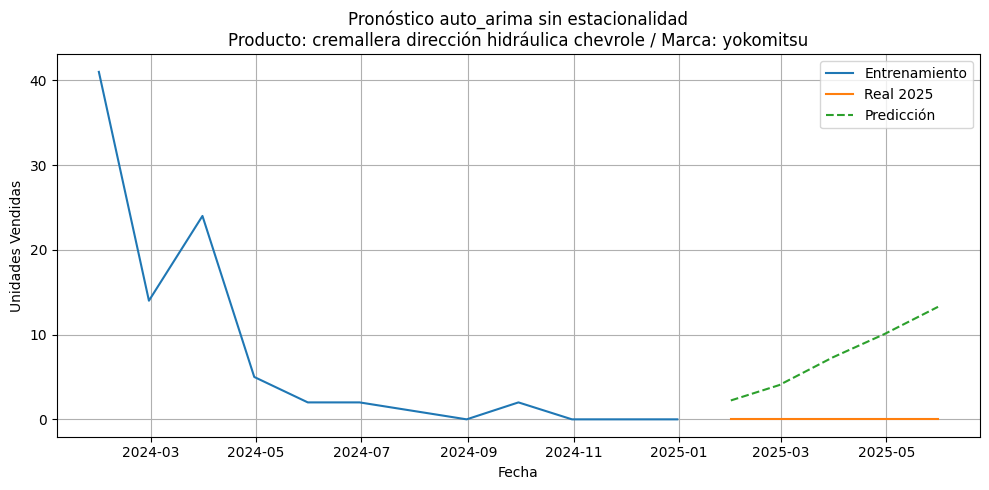

In [ ]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(train["Fecha_Compra"], y_train, label="Entrenamiento")
plt.plot(test["Fecha_Compra"], y_test, label="Real 2025")
plt.plot(test["Fecha_Compra"], predicciones, label="Predicción", linestyle='--')
plt.title(f"Pronóstico auto_arima sin estacionalidad\nProducto: {producto} / Marca: {marca}")
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()